# Deep Learning HW2

Gerald Baulig 0780827 2019/12/02

GitHub: https://github.com/bugerry87/fcnn_scratch

In this assignment we were asked to implement a Convolutional Neural Network (CNN) from scratch.
The CNN has to be demonstrated on two datasets:

1. The MNIST dataset of handwritten digits, and
2. The CIFAR-10 dataset with tiny images of 10 different classes.

# A CNN from Scratch


## The Kernel Convolution


### Indexing


In [51]:
import numpy as np
import numpy.matlib

def indices(xs, ks, stride=(1,1), warp=False):
    kv, ku = ks
    xv, xu = xs
    sv, su = stride
    
    def base(u, k, s):
        u = u+1-k
        K = np.arange(0, k)
        U = np.arange(0, u, s)
        us = U.size
        i = np.reshape(np.tile(K, us), (us, k)) \
            + np.reshape(np.repeat(U, k), (us, k))
        return i
    
    u = base(xu, ku, su)
    if xv == xu and kv == ku:
        v = u.copy()
    else:
        v = base(xv, kv, sv)
    
    shape = (v.shape[0], u.shape[0])
    u = np.matlib.repmat(u, shape[0], kv)
    v = np.repeat(v, ku, axis=1)
    v = np.matlib.repmat(v, shape[1], 1)
    return v, u, shape

## Test
v, u, shape = indices((5,5),(3,3),(2,2))
print("U:\n", u)
print("V:\n", v)

U:
 [[0 1 2 0 1 2 0 1 2]
 [2 3 4 2 3 4 2 3 4]
 [0 1 2 0 1 2 0 1 2]
 [2 3 4 2 3 4 2 3 4]]
V:
 [[0 0 0 1 1 1 2 2 2]
 [2 2 2 3 3 3 4 4 4]
 [0 0 0 1 1 1 2 2 2]
 [2 2 2 3 3 3 4 4 4]]


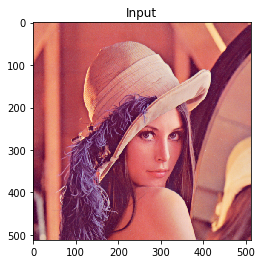

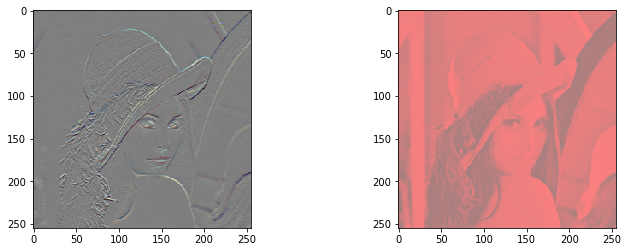

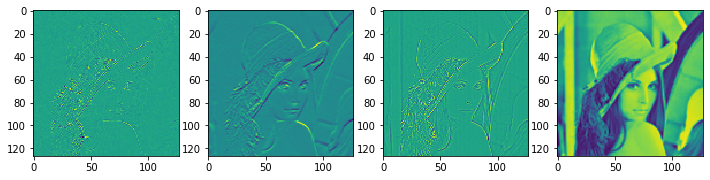

In [106]:
import numpy as np
from PIL import Image
from mynn import FeedFunc

def shape_nvuc(arr):
    if arr.ndim == 4:
        pass
    elif arr.ndim == 2:
        arr = arr[None,:,:,None]
    elif arr.ndim == 3:
        arr = arr[None,:,:,:]
    else:
        raise ValueError("Matrix should have atleast 2dims!")
    return arr, np.array(arr.shape, dtype=int)


def conv_indices(xn, kn, kv, ku):
    indices = np.indices((xn, kn, kv, ku))
    indices = np.reshape(indices, (4, xn * kn * kv * ku))
    indices = np.swapaxes(indices, 0, 1)
    return indices


class Conv2D(FeedFunc):
    def __init__(self, stride=(1,1), norm=('Merge'), cache=True):
        self.stride = stride
        self.norm = norm
        self.cache = cache
        self.uptodate = False
        pass
    
    def f(self, X, K):
        K, ks = shape_nvuc(K)
        X, xs = shape_nvuc(X)
        stv, stu = self.stride
        xs[1:3] -= np.ceil(ks[1:3]/2).astype(int)
        
        if not self.cache:
            indx = conv_indices(xs[0], ks[0], ks[1], ks[2])
            Y = np.zeros((
                int(xs[0]*ks[0]),
                int(np.ceil(xs[1]/stv)),
                int(np.ceil(xs[2]/stu)),
                int(xs[3])
            ))
        elif not self.uptodate:
            self.indices = conv_indices(xs[0], ks[0], ks[1], ks[2])
            self.Y = np.zeros((
                int(xs[0]*ks[0]),
                int(np.ceil(xs[1]/stv)),
                int(np.ceil(xs[2]/stu)),
                int(xs[3])
            ))
            Y = self.Y
            indx = self.indices
            self.uptodate = True
        else:
            Y *= 0

        for xn, kn, v, u in indx:
            V = xs[1] + v
            U = xs[2] + u
            yn = xn * ks[0] + kn
            Y[yn,:,:,:] += X[xn, v:V:stv, u:U:stu] * K[kn,v,u]
        
        if 'Merge' in self.norm:
            Y = np.sum(Y, axis=3, keepdims=True) / xs[3]
            
        if 'AbsMax' in self.norm:
            Y = np.swapaxes(Y, 0, 3)
            Y /= np.max(np.abs(Y), axis=(0,1,2))
            Y = np.swapaxes(Y, 0, 3)
            
        if 'CamReady' in self.norm:
            Y = np.swapaxes(Y, 0, 3)
            Y /= np.max(np.abs(Y), axis=(0,1,2)) * 2
            Y += 0.5
            Y = np.swapaxes(Y, 0, 3)
        return Y
    
    def dw(self, X, dZ):
        return self.f(X, dZ)
    
    def dz(self, dZ, K):
        return self.f(dZ, K)

##test
def test_Conv2D():
    %matplotlib inline
    import matplotlib.pylab as plt
    x = np.asarray(Image.open('Lenna.png'), dtype=float) / 255

    kl1 = np.zeros((2,3,3,3)) ##create 2 3*3kernels with 3 channels
    kl1[0,0,:,:] = -1.
    kl1[0,2,:,:] = 1. ##horiz. haar line filter
    kl1[1,:,:,:] = 0
    kl1[1,:,:,0] = 1. ##red filter

    kl2 = np.zeros((2,3,3,1)) ##create 2 3*3kernels with 3 channels
    kl2[0,:,:,:] = -1.
    kl2[0,1,1,:] = 8. ##outline filter
    kl2[1,:,:,:] = 1. ## opener

    conv1 = Conv2D((2,2), ('CamReady'))
    conv2 = Conv2D((2,2), ('Merge','CamReady'))
    yl1 = conv1.f(x, kl1)
    yl2 = conv2.f(yl1, kl2)

    ## viz
    plt.imshow(x)
    plt.title('Input')
    plt.show()

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,2)
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(yl1[i]))
    plt.show()

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,4)
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(yl2[i]))
    plt.show()
test_Conv2D()

## Max Pooling

In [ ]:
import numpy as np

class MaxPooling():
    def __init__(self,
                 shape
                 input_func,
                 backprop,
                 stride=(1,1)
                ):
        ''''''
        self.input = input_func
        self.backprop = backprop
        self.shape = shape
        self.stride = stride
        pass
    
    def pull_forward(self):
        for self.x in self.input():
            
            np.argmax(self.x, )
            
            self.y
        pass
    
    def push_backward(self, dZ, lr):
        pass


# 1. A CNN for MINIST

## Load n Prepare the MNIST Dataset

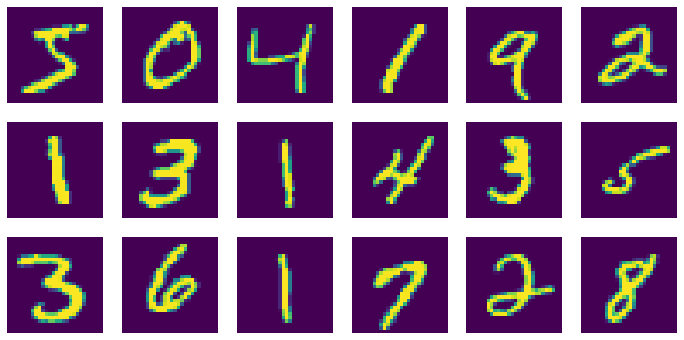

Labels: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8]
Input shape: (18, 28, 28, 1)


In [18]:
import numpy as np

def gen_UBYTES_data(filename, epochs=1, batch_size=1, split=1.0, norm=True, preload=False):
    #read header
    with open(filename, 'rb') as fid:
        mag = int.from_bytes(fid.read(4), byteorder='big')
        N = int.from_bytes(fid.read(4), byteorder='big')
        if mag == 2051:
            row = int.from_bytes(fid.read(4), byteorder='big')
            col = int.from_bytes(fid.read(4), byteorder='big')
        else:
            row = 1
            col = 1
        payload = fid.tell()
    
    #split
    if split > 0:
        N0 = 0
        N = int(N * split)
    else:
        N0 = N + int(N * split)
    
    #read payload batch wise
    step = 0
    if preload:
        with open(filename, 'rb') as fid:
            fid.seek(payload)
            batch = fid.read(N*row*col)
        batch = np.frombuffer(batch, dtype=np.uint8)
        if mag == 2051 and norm:
            batch = batch.astype(float) / 255
        batch = np.reshape(batch, (N, row, col, 1))
        for epoch in range(epochs):
            for n in range(N0,N,batch_size):
                trail = batch_size - (n % batch_size)
                step += trail
                yield batch[n:n+trail], epoch, step
    else:
        for epoch in range(epochs):
            for n in range(N0,N,batch_size):
                with open(filename, 'rb') as fid:
                    fid.seek(payload+n)
                    batch = fid.read(batch_size*row*col)
                    batch = np.frombuffer(batch, dtype=np.uint8)
                if mag == 2051 and norm:
                    batch = batch.astype(float) / 255
                trail = batch_size - (n % batch_size)
                step += trail
                batch = np.reshape(batch, (trail, row, col, 1))
                yield batch, epoch, step
    pass

def to_hot_vector(labels, k):
    N = labels.shape[0]
    hot = np.zeros((N, k))
    hot[range(N),labels] = 1
    return hot

def gen_MNIST_data(
    data="train-images.idx3-ubyte",
    labels="train-labels.idx1-ubyte",
    epochs=1,
    batch_size=1,
    norm=True,
    preload=False
):
    gen_data = gen_UBYTES_data(data, epochs, batch_size, 1, norm, preload)
    gen_labels = gen_UBYTES_data(labels, epochs, batch_size, 1, norm, True)
    for data, label in zip(gen_data, gen_labels):
        X = data[0]
        T = to_hot_vector(np.squeeze(label[0]), 10)
        epoch = X[1]
        step = X[2]
        yield X, T, epoch, step

## test
def test_get_MNIST_data():
    %matplotlib inline
    import matplotlib.pylab as plt
    fig = plt.figure(figsize=(12,6))
    ax = fig.subplots(3,6)
    ax = np.reshape(ax, 6*3)

    ## get one batch and break
    for X, T, _, _ in gen_MNIST_data("train-images.idx3-ubyte", "train-labels.idx1-ubyte", 1, 6*3, norm=False):
        for i, sample in enumerate(X):
            ax[i].set_axis_off()
            ax[i].imshow(np.squeeze(sample))
        break
    plt.show()
    print("Labels:", np.where(np.squeeze(T))[1])
    print("Input shape:", X.shape)
test_get_MNIST_data()

## Configure CNN for MNIST


In [ ]:
import numpy as np
from mynn import (
    NeuralNetwork,
    Layer,
    CrossEntropy,
    ReLU
)

def init_params(n, u, v, c, bias=True, init_func=np.random.randn):
    '''Initialize parameters.
    
    Args:
        n: Number of kernels.
        u, v: shape of the kernel.
        c: Number of channels of the kernel
        bias: True, if a bias should be used, otherwise False.
        init_func: Alter the initialization function.
            (default) np.random.randn
    Returns:
        kernels: A 4-dimensional matrix of weights.
        bias: Either 0 or a vector of biases for each node.
    '''
    kernels = init_func(n, v, u, c)
    return kernels, np.zeros(n) if bias else 0

def init_MNIST_cnn(epochs, batch_size):
    '''
    '''
    cnn = NeuralNetwork(
        train_set = lambda: gen_MNIST_data(
            "train-images.idx3-ubyte",
            "train-labels.idx1-ubyte",
            epochs, 
            batch_size,
            split=0.8
        )
        val_set train_set = lambda: gen_MNIST_data(
            "train-images.idx3-ubyte",
            "train-labels.idx1-ubyte",
            epochs=1, 
            batch_size=1,
            split=-0.2
        )
        cost_func=CrossEntropy
        loss_func=ArgMaxPooling
    )
    
    cnn.In = Layer(
        params=init_params(10,3,3,1),
        input_func=cnn.genInput,
        backprop=None,
        feed_func = Conv2d(stride=(2,2)),
        act_func = ReLU
    ) #(28/2)-2=12
    
    cnn.Conv1 = Layer(
        params=init_params(10,3,3,10),
        input_func=cnn.In.pull_forward,
        backprop=cnn.In.push_backward,
        feed_func = Conv2d(stride=(2,2)),
        act_func = ReLU
    ) #(12/2)-2=4

In [57]:
import numpy as np
np.arange(0,10,2)[None][None]

array([[[0, 2, 4, 6, 8]]])

(65025, 3, 2)
(2, 255, 255, 3)
(16129, 3, 4)
(4, 127, 127, 3)


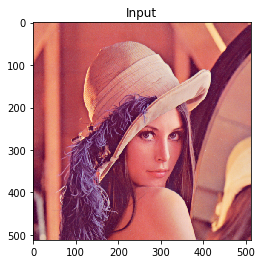

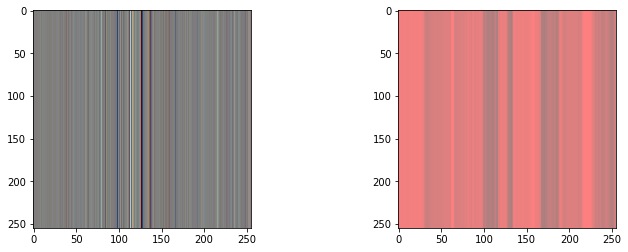

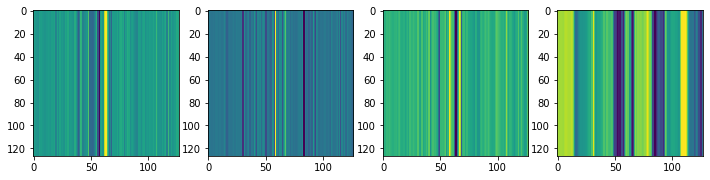

In [101]:
import numpy as np
from PIL import Image
from mynn import FeedFunc

def shape_nvuc(arr):
    if arr.ndim == 4:
        pass
    elif arr.ndim == 2:
        arr = arr[None,:,:,None]
    elif arr.ndim == 3:
        arr = arr[None,:,:,:]
    else:
        raise ValueError("Matrix should have atleast 2dims!")
    return arr, np.array(arr.shape, dtype=int)

class Conv2D(FeedFunc):
    def __init__(self, stride=(1,1), norm=('Merge'), autoupdate=False):
        self.stride = stride
        self.norm = norm
        self.autoupdate = autoupdate
        self.uptodate = False
        pass
    
    def f(self, X, K):
        X, xs = shape_nvuc(X)
        K, ks = shape_nvuc(K)
        K = np.reshape(K, (ks[0], ks[1]*ks[2], ks[3]))
        
        if self.autoupdate or not self.uptodate:
            self.v, self.u, self.shape = indices(xs[1:3], ks[1:3], self.stride)
            self.xs = xs
            self.ks = ks
            self.uptodate = True
        
        xn = np.tile(np.arange(xs[0]), ks[0])
        kn = np.repeat(np.arange(ks[0]), xs[0])
        X = np.moveaxis(X[:,self.v,self.u,:], 0, -1)
        K = np.moveaxis(K, 0, -1)      
        Y = np.sum(X[:, :, :, xn] * K[:,:,kn], axis=1)
        print(Y.shape)
        Y = np.reshape(Y, (self.shape[0], self.shape[1], xs[3], xn.size))
        Y = np.moveaxis(Y, -1, 0)
        print(Y.shape)
        
        if 'Merge' in self.norm:
            Y = np.sum(Y, axis=3, keepdims=True) / xs[3]
            
        if 'AbsMax' in self.norm:
            Y = np.swapaxes(Y, 0, 3)
            Y /= np.max(np.abs(Y), axis=(0,1,2))
            Y = np.swapaxes(Y, 0, 3)
            
        if 'CamReady' in self.norm:
            Y = np.swapaxes(Y, 0, 3)
            Y /= np.max(np.abs(Y), axis=(0,1,2)) * 2
            Y += 0.5
            Y = np.swapaxes(Y, 0, 3)
        return Y
    
    def dw(self, X, dZ):
        return self.f(X, dZ)
    
    def dz(self, dZ, K):
        return self.f(dZ, K)

## Test
def test_Conv2D():
    %matplotlib inline
    import matplotlib.pylab as plt
    x = np.asarray(Image.open('Lenna.png'), dtype=float) / 255

    kl1 = np.zeros((2,3,3,3)) ##create 2 3*3kernels with 3 channels
    kl1[0,0,:,:] = -1.
    kl1[0,2,:,:] = 1. ##horiz. haar line filter
    kl1[1,:,:,:] = 0
    kl1[1,:,:,0] = 1. ##red filter

    kl2 = np.zeros((2,3,3,1)) ##create 2 3*3kernels with 3 channels
    kl2[0,:,:,:] = -1.
    kl2[0,1,1,:] = 8. ##outline filter
    kl2[1,:,:,:] = 1. ## opener

    conv1 = Conv2D((2,2), ('CamReady'))
    conv2 = Conv2D((2,2), ('Merge','CamReady'))
    yl1 = conv1.f(x, kl1)
    yl2 = conv2.f(yl1, kl2)

    ## viz
    plt.imshow(x)
    plt.title('Input')
    plt.show()

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,2)
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(yl1[i]))
    plt.show()

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,4)
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(yl2[i]))
    plt.show()
test_Conv2D()